# Goal

We will attemp to convert English into Pig Latin.  We will use the Text8 data as a corpus of text.  The modeling will be done using a sequence of characters and the input sequence will be the sequence of characters for one word.  We will use the method described [here](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) 

# Import functions

In [1]:
import pickle
import tensorflow as tf
import numpy as np
import string
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
%matplotlib inline

# Import data

In [2]:
words = pickle.load(open('t8_words.p'))
words_pl = pickle.load(open('t8_words_pl.p'))

In [3]:
print zip(words[:10],words_pl[:10])

[('biennials', 'iennialsbay'), ('tripolitan', 'ipolitantray'), ('mdbg', 'mdbgay'), ('roadgear', 'oadgearray'), ('vang', 'angvay'), ('nunnery', 'unnerynay'), ('sowell', 'owellsay'), ('brownpride', 'ownpridebray'), ('vani', 'anivay'), ('woods', 'oodsway')]


# Create validation set

Taken from [here](https://en.oxforddictionaries.com/explore/weird-and-wonderful-words)

In [4]:
def lessT(x):
    if x <= 10:
        return True
    return False

In [5]:
uncommon = ['abaya','bardolatry','blatherski','couthy','deterge','eyewater','saudade',
            'tokoloshe','wittol','vomitous','waitron']
assert (not any([u in words for u in uncommon]))
assert all(map(lessT,map(len,uncommon)))

# Padding inputs and outputs

There is no good way to handle sequences of multiple lengths (see [here](https://www.tensorflow.org/tutorials/seq2seq)).  So we pad inputs and outputs to fixed lengths.

In [6]:
# find maximum length of input
max_in = 0
ind = 0
for i,w in enumerate(words):
    if len(w)> max_in:
        max_in = len(w)
        ind = i
print max_in, words[ind]

10 tripolitan


In [7]:
# find maximum length of input
max_out = 0
ind = 0
for i,w in enumerate(words_pl):
    if len(w)> max_out:
        max_out = len(w)
        ind = i
print max_out, words_pl[ind]

13 altagraciaway


In [8]:
pad_char = '~'
def pad_in(w):
    while(len(w)<max_in):
        w = pad_char+w
    return w

def pad_out(w):
    while(len(w)<max_out):
        w = w+pad_char
    return w

def un_pad(w):
    return w.replace(pad_char,'')

In [9]:
print pad_in(words[0])
print pad_out(words_pl[0])

~biennials
iennialsbay~~


# Vectorize data

In [10]:
alphabet = string.ascii_lowercase+'~'
alphabet_size = len(alphabet)+1 #need to add one for the end of sequence key

#returns a unique integer for the letter
def char2id(x):
    return alphabet.find(x)

#return a one hot encoded vector of the letter
def one_hot(l):
    r = np.zeros(alphabet_size)
    r[char2id(l)] = 1.0
    return r

#return the letter of the one-hot encoded letter
def un_one_hot(v):
    ind = np.argmax(v)
#     if ind >= alphabet_size-2:
    if ind == alphabet_size-1:
        return ''
    else:
        return alphabet[ind]

#returns the the End of Sequence vector
def getEOSvec():
    r = np.zeros(alphabet_size)
    r[alphabet_size-1] = 1.0
    return r

#returns the word a matrix of one hot encoded vectors
def vectorizeWord(w):
    r = np.ndarray((len(w)+1,alphabet_size))
    for i,l in enumerate(w):
        r[i] = one_hot(l)
    r[len(w)] = getEOSvec()
    return r

#returns the string of the vectorized word
def unvectorizeWord(M):
    r = ''
    for i in xrange(M.shape[0]):
        r += un_one_hot(M[i])
    return r

# Batch Generator

In [11]:
batch_size=30

In [12]:
class Batch(object):
    def __init__(self,words,words_pl,batch_size):
        self.words = words
        self.words_pl = words_pl
        self.batch_size = batch_size
        self.size = len(words)
        self.segment_size = self.size/batch_size
        self.cursors = [b*self.segment_size for b in range(batch_size)]
        #self.batch = np.ndarray(self.batch_size)
    def nextBatch(self,reverse = True):
        if reverse:
            x = np.array([vectorizeWord(pad_in(words[c][::-1])) for c in self.cursors])
        else:
            x = np.array([vectorizeWord(pad_in(words[c])) for c in self.cursors])
        y = np.array([vectorizeWord(pad_out(words_pl[c])) for c in self.cursors])
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return x,y

# Deep Traditional

https://arxiv.org/pdf/1409.2329.pdf

<img src="Notes/OtherLSTM.png">

In [13]:
#NOTE: the +1 in max_in+1 and max_out+1 happens because the end token is needed

num_nodes = 500
g = tf.Graph()
with g.as_default():
    #input sequence
    input_sequence = list()
    for i in range(max_in+1):
        input_sequence.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #target sequence
    target_sequence = list()
    for i in range(max_out+1):
        target_sequence.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #the previous state that gets fed into the cell
    state_0 = tf.constant(0.0,dtype=tf.float32,shape=[batch_size,num_nodes])
    hidden_0 = tf.constant(0.0,dtype=tf.float32,shape=[batch_size,num_nodes])
    #for validation inference
    state_0v = tf.constant(0.0,dtype=tf.float32,shape=[1,num_nodes])
    hidden_0v = tf.constant(0.0,dtype=tf.float32,shape=[1,num_nodes])
    
    def create_LSTM_Variables(num_nodes,Name,is_input=False):
        if is_input:
            fx = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'fx')
            ix = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'ix')
            cx = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'cx')
            ox = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'ox')
        else:
            fx = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'fx')
            ix = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'ix')
            cx = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'cx')
            ox = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'ox')
        fb = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'fb')
        ib = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'ib')
        cb = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'cb')
        ob = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'ob')
        return[[fx,ix,cx,ox],[fb,ib,cb,ob]]
    
    e1_var = create_LSTM_Variables(num_nodes,'e1',is_input = True)
    e2_var = create_LSTM_Variables(num_nodes,'e2')
    e3_var = create_LSTM_Variables(num_nodes,'e3')
    
    d1_var = create_LSTM_Variables(num_nodes,'d1',is_input = True)
    d2_var = create_LSTM_Variables(num_nodes,'d2')
    d3_var = create_LSTM_Variables(num_nodes,'d3')
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.08,0.08))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    #model
    #hl is the previous hiddent layer from current time step but previous  layer
    #ht is the previous hidden layer from the current layer but previous timestep
    #state is the previous state from the same layer but previous timestep
    def LSTM(hl,ht,state,varrs):
        #get variables out
        x,b=varrs[0],varrs[1]
        fx,ix,cx,ox = x[0],x[1],x[2],x[3]
        fb,ib,cb,ob = b[0],b[1],b[1],b[3]
        
        #computations
        input_chan = tf.concat([hl,ht],1)
        forget_gate = tf.sigmoid(tf.matmul(input_chan,fx)+fb)
        insert_gate = tf.sigmoid(tf.matmul(input_chan,ix)+ib)
        output_gate = tf.sigmoid(tf.matmul(input_chan,ox)+ob)
        candidate = tf.tanh(tf.matmul(input_chan,cx)+cb)
        state = forget_gate * state + insert_gate * candidate
        h = output_gate * tf.tanh(state)
        return h, state
    
    
    def model(input_sequence,train = True):
        #Encode sequence
        for i in range(max_in+1):
            if i == 0:
                if train:
                    state1,h1 = state_0,hidden_0
                    state2,h2 = state_0,hidden_0
                    state3,h3 = state_0,hidden_0
                else:
                    state1,h1 = state_0v,hidden_0v
                    state2,h2 = state_0v,hidden_0v
                    state3,h3 = state_0v,hidden_0v

            h1,state1 = LSTM(h1,input_sequence[i],state1,e1_var) #layer 1
            h2,state2 = LSTM(h2,h1,state2,e2_var) #layer 2
            h3,state3 = LSTM(h3,h2,state3,e3_var) #layer 3

        #Decode sequence
        logits_list = list()
        for i in range(max_out+1):
            if i == 0:
                h1,state1 = LSTM(h1,input_sequence[-1],state1,d1_var) #layer 1

            else:
                h1,state1 = LSTM(h1,tf.nn.softmax(logit),state1,d1_var) #layer 1
            h2,state2 = LSTM(h2,h1,state2,d2_var) #layer 2
            h3,state3 = LSTM(h3,h2,state3,d3_var) #layer 3

            logit =tf.matmul(h3,W_softmax)+b_softmax
            logits_list.append(logit)

        logits = tf.concat(logits_list,0)
        return logits
    
    #train
    logits_train = model(input_sequence)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_train,labels=tf.concat(target_sequence,0)))
    opt = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
    
    #inference train
    pred = tf.nn.softmax(logits_train)
    
    saver = tf.train.Saver()
        
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [14]:
sess = tf.Session(graph = g)
sess.run(init)
b = Batch(words,words_pl,batch_size)
losses = []

In [15]:
saver.restore(sess,os.getcwd()+'/model3.ckpt')

In [34]:
num_steps = 10001
for s in tqdm(range(num_steps)):
    fd = {}
    x,y = b.nextBatch(reverse=True)
    for i in range(len(x[0,:,0])):
        fd[input_sequence[i]] = x[:,i,:]
    for i in range(len(y[0,:,0])):
        fd[target_sequence[i]] = y[:,i,:]
    
    l,_ = sess.run([loss,opt],feed_dict = fd)
    losses.append(l)
    if s % 100 == 0:
        translated = sess.run([pred],feed_dict=fd)[0]
        #onlt check the first word
        fw_o = np.ndarray((max_out,alphabet_size))
        for i in range(max_out):
            fw_o[i]=translated[i*batch_size]
    
        print 'loss: ',l
        print 'Input:          ',unvectorizeWord(x[0])[::-1]
        print 'Output:         ',unvectorizeWord(fw_o)
        print 'Correct Output: ',unvectorizeWord(y[0])
        print ' '
save_path = saver.save(sess,os.getcwd()+'/model3.ckpt')

  0%|          | 2/10001 [00:00<40:59,  4.06it/s]

loss:  0.0397508
Input:           hitman~~~~
Output:          itmanhay~~~~~
Correct Output:  itmanhay~~~~~
 


  1%|          | 102/10001 [00:14<25:10,  6.55it/s]

loss:  0.0890046
Input:           acrophoca~
Output:          acrophocaway~
Correct Output:  acrophocaway~
 


  2%|▏         | 202/10001 [00:28<24:47,  6.59it/s]

loss:  0.0467599
Input:           gradualist
Output:          adualissgray~
Correct Output:  adualistgray~
 


  3%|▎         | 302/10001 [00:42<24:41,  6.55it/s]

loss:  0.0531499
Input:           shoreditch
Output:          oreditchshay~
Correct Output:  oreditchshay~
 


  4%|▍         | 402/10001 [00:56<23:56,  6.68it/s]

loss:  0.0190368
Input:           falmes~~~~
Output:          almesfay~~~~~
Correct Output:  almesfay~~~~~
 


  5%|▌         | 502/10001 [01:10<24:03,  6.58it/s]

loss:  0.0200205
Input:           fatman~~~~
Output:          atmanfay~~~~~
Correct Output:  atmanfay~~~~~
 


  6%|▌         | 602/10001 [01:23<23:27,  6.68it/s]

loss:  0.0417676
Input:           harvia~~~~
Output:          arviahay~~~~~
Correct Output:  arviahay~~~~~
 


  7%|▋         | 702/10001 [01:37<23:10,  6.69it/s]

loss:  0.047642
Input:           satelite~~
Output:          atelitesay~~~
Correct Output:  atelitesay~~~
 


  8%|▊         | 802/10001 [01:51<23:09,  6.62it/s]

loss:  0.0477612
Input:           acastus~~~
Output:          acastusway~~~
Correct Output:  acastusway~~~
 


  9%|▉         | 902/10001 [02:05<23:04,  6.57it/s]

loss:  0.143832
Input:           handelian~
Output:          andelianhay~~
Correct Output:  andelianhay~~
 


 10%|█         | 1002/10001 [02:19<22:33,  6.65it/s]

loss:  0.0366347
Input:           upuaut~~~~
Output:          upuautway~~~~
Correct Output:  upuautway~~~~
 


 11%|█         | 1102/10001 [02:33<22:16,  6.66it/s]

loss:  0.0250275
Input:           nhengatu~~
Output:          engatunhay~~~
Correct Output:  engatunhay~~~
 


 12%|█▏        | 1202/10001 [02:47<22:00,  6.66it/s]

loss:  0.00846265
Input:           argens~~~~
Output:          argensway~~~~
Correct Output:  argensway~~~~
 


 13%|█▎        | 1302/10001 [03:00<21:30,  6.74it/s]

loss:  0.00727819
Input:           pitseolak~
Output:          itseolakpay~~
Correct Output:  itseolakpay~~
 


 14%|█▍        | 1402/10001 [03:14<21:24,  6.69it/s]

loss:  0.0158179
Input:           spamming~~
Output:          ammingspay~~~
Correct Output:  ammingspay~~~
 


 15%|█▌        | 1502/10001 [03:28<21:11,  6.68it/s]

loss:  0.0537208
Input:           concurring
Output:          oncurringcay~
Correct Output:  oncurringcay~
 


 16%|█▌        | 1602/10001 [03:42<21:07,  6.63it/s]

loss:  0.0162185
Input:           kinnor~~~~
Output:          innorkay~~~~~
Correct Output:  innorkay~~~~~
 


 17%|█▋        | 1702/10001 [03:56<20:37,  6.71it/s]

loss:  0.0155271
Input:           chabahar~~
Output:          abaharchay~~~
Correct Output:  abaharchay~~~
 


 18%|█▊        | 1802/10001 [04:10<20:25,  6.69it/s]

loss:  0.0110759
Input:           foundries~
Output:          oundriesfay~~
Correct Output:  oundriesfay~~
 


 19%|█▉        | 1902/10001 [04:24<20:16,  6.66it/s]

loss:  0.0468212
Input:           hardened~~
Output:          ardenedhay~~~
Correct Output:  ardenedhay~~~
 


 20%|██        | 2002/10001 [04:37<19:51,  6.71it/s]

loss:  0.013148
Input:           sudayev~~~
Output:          udayevsay~~~~
Correct Output:  udayevsay~~~~
 


 21%|██        | 2102/10001 [04:51<19:44,  6.67it/s]

loss:  0.0230214
Input:           bangala~~~
Output:          angalabay~~~~
Correct Output:  angalabay~~~~
 


 22%|██▏       | 2202/10001 [05:05<19:37,  6.63it/s]

loss:  0.0694269
Input:           sashay~~~~
Output:          ashaysay~~~~~
Correct Output:  ashaysay~~~~~
 


 23%|██▎       | 2302/10001 [05:19<19:12,  6.68it/s]

loss:  0.0168241
Input:           browns~~~~
Output:          ownsbray~~~~~
Correct Output:  ownsbray~~~~~
 


 24%|██▍       | 2402/10001 [05:33<18:51,  6.71it/s]

loss:  0.020921
Input:           torslanda~
Output:          orslandatay~~
Correct Output:  orslandatay~~
 


 25%|██▌       | 2502/10001 [05:47<18:38,  6.71it/s]

loss:  0.00612141
Input:           beilein~~~
Output:          eileinbay~~~~
Correct Output:  eileinbay~~~~
 


 26%|██▌       | 2602/10001 [06:01<18:37,  6.62it/s]

loss:  0.12121
Input:           precisely~
Output:          eciselypray~~
Correct Output:  eciselypray~~
 


 27%|██▋       | 2702/10001 [06:15<18:11,  6.69it/s]

loss:  0.0294976
Input:           baset~~~~~
Output:          asetbay~~~~~~
Correct Output:  asetbay~~~~~~
 


 28%|██▊       | 2802/10001 [06:28<18:02,  6.65it/s]

loss:  0.0154911
Input:           sara~~~~~~
Output:          arasay~~~~~~~
Correct Output:  arasay~~~~~~~
 


 29%|██▉       | 2902/10001 [06:42<17:42,  6.68it/s]

loss:  0.0721428
Input:           alberich~~
Output:          alberichway~~
Correct Output:  alberichway~~
 


 30%|███       | 3002/10001 [06:56<17:25,  6.70it/s]

loss:  0.0244757
Input:           washington
Output:          ashingtonway~
Correct Output:  ashingtonway~
 


 31%|███       | 3102/10001 [07:10<17:13,  6.68it/s]

loss:  0.013625
Input:           ainge~~~~~
Output:          aingeway~~~~~
Correct Output:  aingeway~~~~~
 


 32%|███▏      | 3202/10001 [07:24<16:55,  6.70it/s]

loss:  0.0238382
Input:           shoyu~~~~~
Output:          oyushay~~~~~~
Correct Output:  oyushay~~~~~~
 


 33%|███▎      | 3302/10001 [07:38<16:46,  6.66it/s]

loss:  0.0040582
Input:           artifax~~~
Output:          artifaxway~~~
Correct Output:  artifaxway~~~
 


 34%|███▍      | 3402/10001 [07:52<16:27,  6.68it/s]

loss:  0.0130418
Input:           praef~~~~~
Output:          aefpray~~~~~~
Correct Output:  aefpray~~~~~~
 


 35%|███▌      | 3502/10001 [08:05<16:37,  6.51it/s]

loss:  0.0210094
Input:           silvan~~~~
Output:          ilvansay~~~~~
Correct Output:  ilvansay~~~~~
 


 36%|███▌      | 3602/10001 [08:19<15:50,  6.74it/s]

loss:  0.00807344
Input:           campechana
Output:          ampechanacay~
Correct Output:  ampechanacay~
 


 37%|███▋      | 3702/10001 [08:33<15:42,  6.68it/s]

loss:  0.00700189
Input:           khoon~~~~~
Output:          oonkhay~~~~~~
Correct Output:  oonkhay~~~~~~
 


 38%|███▊      | 3802/10001 [08:47<15:28,  6.68it/s]

loss:  0.0327652
Input:           chenoweth~
Output:          enowethchay~~
Correct Output:  enowethchay~~
 


 39%|███▉      | 3902/10001 [09:01<15:14,  6.67it/s]

loss:  0.0353299
Input:           habaki~~~~
Output:          abakihay~~~~~
Correct Output:  abakihay~~~~~
 


 40%|████      | 4002/10001 [09:15<14:53,  6.71it/s]

loss:  0.0107798
Input:           ayr~~~~~~~
Output:          ayrway~~~~~~~
Correct Output:  ayrway~~~~~~~
 


 41%|████      | 4102/10001 [09:29<14:47,  6.64it/s]

loss:  0.0452816
Input:           gck~~~~~~~
Output:          gckay~~~~~~~~
Correct Output:  gckay~~~~~~~~
 


 42%|████▏     | 4202/10001 [09:43<14:32,  6.65it/s]

loss:  0.00631964
Input:           holdereri~
Output:          oldererihay~~
Correct Output:  oldererihay~~
 


 43%|████▎     | 4302/10001 [09:56<14:16,  6.65it/s]

loss:  0.0288325
Input:           andreanof~
Output:          andreanofway~
Correct Output:  andreanofway~
 


 44%|████▍     | 4402/10001 [10:10<14:08,  6.60it/s]

loss:  0.01043
Input:           amorc~~~~~
Output:          amorcway~~~~~
Correct Output:  amorcway~~~~~
 


 45%|████▌     | 4502/10001 [10:24<13:54,  6.59it/s]

loss:  0.021064
Input:           ronique~~~
Output:          oniqueray~~~~
Correct Output:  oniqueray~~~~
 


 46%|████▌     | 4602/10001 [10:38<13:20,  6.74it/s]

loss:  0.00736155
Input:           prespa~~~~
Output:          espapray~~~~~
Correct Output:  espapray~~~~~
 


 47%|████▋     | 4702/10001 [10:52<13:09,  6.71it/s]

loss:  0.00578366
Input:           gijbels~~~
Output:          ijbelsgay~~~~
Correct Output:  ijbelsgay~~~~
 


 48%|████▊     | 4802/10001 [11:06<12:56,  6.69it/s]

loss:  0.0453917
Input:           lambertus~
Output:          ambertuslay~~
Correct Output:  ambertuslay~~
 


 49%|████▉     | 4902/10001 [11:20<12:39,  6.71it/s]

loss:  0.0244095
Input:           douses~~~~
Output:          ousesday~~~~~
Correct Output:  ousesday~~~~~
 


 50%|█████     | 5002/10001 [11:33<12:30,  6.66it/s]

loss:  0.00887534
Input:           sbc~~~~~~~
Output:          sbcay~~~~~~~~
Correct Output:  sbcay~~~~~~~~
 


 51%|█████     | 5102/10001 [11:47<12:09,  6.71it/s]

loss:  0.0944989
Input:           ebury~~~~~
Output:          eburyway~~~~~
Correct Output:  eburyway~~~~~
 


 52%|█████▏    | 5202/10001 [12:01<11:57,  6.69it/s]

loss:  0.00906647
Input:           hotdiary~~
Output:          otdiaryhay~~~
Correct Output:  otdiaryhay~~~
 


 53%|█████▎    | 5302/10001 [12:15<11:40,  6.71it/s]

loss:  0.0041696
Input:           dahs~~~~~~
Output:          ahsday~~~~~~~
Correct Output:  ahsday~~~~~~~
 


 54%|█████▍    | 5402/10001 [12:29<11:32,  6.65it/s]

loss:  0.0204484
Input:           adamanthea
Output:          adamantheaway
Correct Output:  adamantheaway
 


 55%|█████▌    | 5502/10001 [12:43<11:12,  6.69it/s]

loss:  0.00591059
Input:           polferries
Output:          olferriespay~
Correct Output:  olferriespay~
 


 56%|█████▌    | 5602/10001 [12:57<10:57,  6.69it/s]

loss:  0.0286744
Input:           unomig~~~~
Output:          unomigway~~~~
Correct Output:  unomigway~~~~
 


 57%|█████▋    | 5702/10001 [13:11<10:42,  6.69it/s]

loss:  0.00551149
Input:           lame~~~~~~
Output:          amelay~~~~~~~
Correct Output:  amelay~~~~~~~
 


 58%|█████▊    | 5802/10001 [13:24<10:26,  6.70it/s]

loss:  0.009475
Input:           amathos~~~
Output:          amathosway~~~
Correct Output:  amathosway~~~
 


 59%|█████▉    | 5902/10001 [13:38<10:18,  6.63it/s]

loss:  0.00236253
Input:           yeni~~~~~~
Output:          eniyay~~~~~~~
Correct Output:  eniyay~~~~~~~
 


 60%|██████    | 6002/10001 [13:52<09:55,  6.71it/s]

loss:  0.00747156
Input:           xdr~~~~~~~
Output:          xdray~~~~~~~~
Correct Output:  xdray~~~~~~~~
 


 61%|██████    | 6102/10001 [14:06<09:41,  6.70it/s]

loss:  0.00796936
Input:           teamtennis
Output:          eamtennistay~
Correct Output:  eamtennistay~
 


 62%|██████▏   | 6202/10001 [14:20<09:24,  6.73it/s]

loss:  0.0191322
Input:           kodex~~~~~
Output:          odexkay~~~~~~
Correct Output:  odexkay~~~~~~
 


 63%|██████▎   | 6302/10001 [14:34<09:11,  6.70it/s]

loss:  0.0153578
Input:           maaouiya~~
Output:          aaouiyamay~~~
Correct Output:  aaouiyamay~~~
 


 64%|██████▍   | 6402/10001 [14:48<09:00,  6.66it/s]

loss:  0.0191571
Input:           philomena~
Output:          ilomenaphay~~
Correct Output:  ilomenaphay~~
 


 65%|██████▌   | 6502/10001 [15:01<08:48,  6.62it/s]

loss:  0.00157448
Input:           vibronic~~
Output:          ibronicvay~~~
Correct Output:  ibronicvay~~~
 


 66%|██████▌   | 6602/10001 [15:15<08:35,  6.59it/s]

loss:  0.0221823
Input:           wursig~~~~
Output:          ursigway~~~~~
Correct Output:  ursigway~~~~~
 


 67%|██████▋   | 6702/10001 [15:29<08:15,  6.66it/s]

loss:  0.00581623
Input:           hauhet~~~~
Output:          auhethay~~~~~
Correct Output:  auhethay~~~~~
 


 68%|██████▊   | 6802/10001 [15:43<07:59,  6.67it/s]

loss:  0.0294582
Input:           carrero~~~
Output:          arrerocay~~~~
Correct Output:  arrerocay~~~~
 


 69%|██████▉   | 6902/10001 [15:57<07:51,  6.58it/s]

loss:  0.0635391
Input:           overstep~~
Output:          overstepway~~
Correct Output:  overstepway~~
 


 70%|███████   | 7002/10001 [16:11<07:32,  6.63it/s]

loss:  0.0209803
Input:           earthshine
Output:          earthshineway
Correct Output:  earthshineway
 


 71%|███████   | 7102/10001 [16:25<07:24,  6.52it/s]

loss:  0.0161009
Input:           cabalah~~~
Output:          abalahcay~~~~
Correct Output:  abalahcay~~~~
 


 72%|███████▏  | 7202/10001 [16:38<06:57,  6.71it/s]

loss:  0.0169639
Input:           haheim~~~~
Output:          aheimhay~~~~~
Correct Output:  aheimhay~~~~~
 


 73%|███████▎  | 7302/10001 [16:52<06:42,  6.71it/s]

loss:  0.00323543
Input:           judg~~~~~~
Output:          udgjay~~~~~~~
Correct Output:  udgjay~~~~~~~
 


 74%|███████▍  | 7402/10001 [17:06<06:27,  6.70it/s]

loss:  0.0172077
Input:           nzhistory~
Output:          istorynzhay~~
Correct Output:  istorynzhay~~
 


 75%|███████▌  | 7502/10001 [17:20<06:12,  6.71it/s]

loss:  0.0765051
Input:           terrifying
Output:          errifyingtay~
Correct Output:  errifyingtay~
 


 76%|███████▌  | 7602/10001 [17:34<05:57,  6.70it/s]

loss:  0.00480869
Input:           shayol~~~~
Output:          ayolshay~~~~~
Correct Output:  ayolshay~~~~~
 


 77%|███████▋  | 7702/10001 [17:48<05:44,  6.68it/s]

loss:  0.061703
Input:           pot~~~~~~~
Output:          otpay~~~~~~~~
Correct Output:  otpay~~~~~~~~
 


 78%|███████▊  | 7802/10001 [18:02<05:26,  6.73it/s]

loss:  0.0119456
Input:           cohortatio
Output:          ohortatiocay~
Correct Output:  ohortatiocay~
 


 79%|███████▉  | 7902/10001 [18:15<05:11,  6.75it/s]

loss:  0.00439903
Input:           preceding~
Output:          ecedingpray~~
Correct Output:  ecedingpray~~
 


 80%|████████  | 8002/10001 [18:29<05:02,  6.61it/s]

loss:  0.00507624
Input:           watc~~~~~~
Output:          atcway~~~~~~~
Correct Output:  atcway~~~~~~~
 


 81%|████████  | 8102/10001 [18:43<04:43,  6.69it/s]

loss:  0.00885867
Input:           wacho~~~~~
Output:          achoway~~~~~~
Correct Output:  achoway~~~~~~
 


 82%|████████▏ | 8202/10001 [18:57<04:27,  6.72it/s]

loss:  0.00653249
Input:           oya~~~~~~~
Output:          oyaway~~~~~~~
Correct Output:  oyaway~~~~~~~
 


 83%|████████▎ | 8302/10001 [19:11<04:13,  6.70it/s]

loss:  0.00292199
Input:           ided~~~~~~
Output:          idedway~~~~~~
Correct Output:  idedway~~~~~~
 


 84%|████████▍ | 8402/10001 [19:25<03:58,  6.69it/s]

loss:  0.042033
Input:           apostolini
Output:          apostoliniway
Correct Output:  apostoliniway
 


 85%|████████▌ | 8502/10001 [19:39<03:43,  6.70it/s]

loss:  0.0023928
Input:           rubles~~~~
Output:          ublesray~~~~~
Correct Output:  ublesray~~~~~
 


 86%|████████▌ | 8602/10001 [19:52<03:29,  6.68it/s]

loss:  0.0585883
Input:           owada~~~~~
Output:          owadaway~~~~~
Correct Output:  owadaway~~~~~
 


 87%|████████▋ | 8702/10001 [20:06<03:16,  6.61it/s]

loss:  0.0459611
Input:           sylacauga~
Output:          acaugasylay~~
Correct Output:  acaugasylay~~
 


 88%|████████▊ | 8802/10001 [20:20<02:59,  6.68it/s]

loss:  0.00238391
Input:           msm~~~~~~~
Output:          msmay~~~~~~~~
Correct Output:  msmay~~~~~~~~
 


 89%|████████▉ | 8902/10001 [20:34<02:45,  6.65it/s]

loss:  0.0021305
Input:           edp~~~~~~~
Output:          edpway~~~~~~~
Correct Output:  edpway~~~~~~~
 


 90%|█████████ | 9002/10001 [20:48<02:28,  6.71it/s]

loss:  0.00604852
Input:           kudzu~~~~~
Output:          udzukay~~~~~~
Correct Output:  udzukay~~~~~~
 


 91%|█████████ | 9102/10001 [21:02<02:15,  6.62it/s]

loss:  0.00932008
Input:           batam~~~~~
Output:          atambay~~~~~~
Correct Output:  atambay~~~~~~
 


 92%|█████████▏| 9202/10001 [21:16<01:58,  6.74it/s]

loss:  0.0711325
Input:           beatman~~~
Output:          eatmanbay~~~~
Correct Output:  eatmanbay~~~~
 


 93%|█████████▎| 9302/10001 [21:30<01:44,  6.71it/s]

loss:  0.00198263
Input:           libellous~
Output:          ibellouslay~~
Correct Output:  ibellouslay~~
 


 94%|█████████▍| 9402/10001 [21:43<01:29,  6.67it/s]

loss:  0.0122379
Input:           ashtekar~~
Output:          ashtekarway~~
Correct Output:  ashtekarway~~
 


 95%|█████████▌| 9502/10001 [21:57<01:14,  6.68it/s]

loss:  0.00157204
Input:           suuret~~~~
Output:          uuretsay~~~~~
Correct Output:  uuretsay~~~~~
 


 96%|█████████▌| 9602/10001 [22:11<00:59,  6.68it/s]

loss:  0.00577629
Input:           hankuk~~~~
Output:          ankukhay~~~~~
Correct Output:  ankukhay~~~~~
 


 97%|█████████▋| 9702/10001 [22:25<00:44,  6.73it/s]

loss:  0.0035874
Input:           samsung~~~
Output:          amsungsay~~~~
Correct Output:  amsungsay~~~~
 


 98%|█████████▊| 9802/10001 [22:39<00:30,  6.63it/s]

loss:  0.00221084
Input:           elevations
Output:          elevationsway
Correct Output:  elevationsway
 


 99%|█████████▉| 9902/10001 [22:53<00:14,  6.61it/s]

loss:  0.00571501
Input:           ammine~~~~
Output:          ammineway~~~~
Correct Output:  ammineway~~~~
 


100%|██████████| 10001/10001 [23:06<00:00,  6.48it/s]


loss:  0.00227702
Input:           nobles~~~~
Output:          oblesnay~~~~~
Correct Output:  oblesnay~~~~~
 


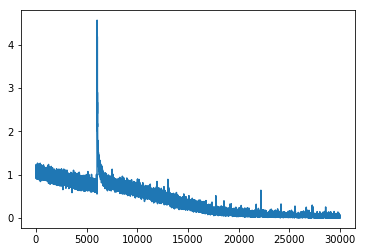

In [23]:
plt.plot(losses)

In [24]:
with g.as_default():
    val_sequence = list()
    for i in range(max_in+1):
        val_sequence.append(tf.placeholder(tf.float32,shape=(1,alphabet_size)))
    logits_val = model(val_sequence,train=False)
    pred_val = tf.nn.softmax(logits_val)

In [25]:
#validation
for s in range(len(uncommon)):
    inputs = vectorizeWord(pad_in(uncommon[s][::-1]))
    
    fd = {}
    for i in range(len(inputs)):
        fd[val_sequence[i]] = np.expand_dims(inputs[i],0)
    
    translated = sess.run([pred_val],feed_dict=fd)[0]
    print 'Input:          ',uncommon[s]
    print 'Output:         ',unvectorizeWord(translated)
    print ' '

Input:           abaya
Output:          abayaway~~~~~
 
Input:           bardolatry
Output:          ardolatrybay~
 
Input:           blatherski
Output:          atherskiblay~
 
Input:           couthy
Output:          outhycay~~~~~
 
Input:           deterge
Output:          etergeday~~~~
 
Input:           eyewater
Output:          eyewaterway~~
 
Input:           saudade
Output:          audadesay~~~~
 
Input:           tokoloshe
Output:          okoloshetay~~
 
Input:           wittol
Output:          ittolway~~~~~
 
Input:           vomitous
Output:          omitousvay~~~
 
Input:           waitron
Output:          aitronway~~~~
 


# Get Variables

In [32]:
model_params = sess.run([e1_var,e2_var,e3_var,d1_var,d2_var,d3_var,W_softmax,b_softmax])

In [33]:
pickle.dump(model_params,open('params.p','w'))